In [1]:
import pennylane as qml
from pennylane import numpy as np
from functools import partial
import matplotlib.pyplot as plt
from qubit_models import *
from helpers import *

In [2]:
from datasets import *

# train_X, test_X, train_y, test_y = get_xor_data(500)
train_X, test_X, train_y, test_y = get_circular_boundary_dataset(500)
# train_X, test_X, train_y, test_y = get_moon_dataset(500)
len(train_X)

450

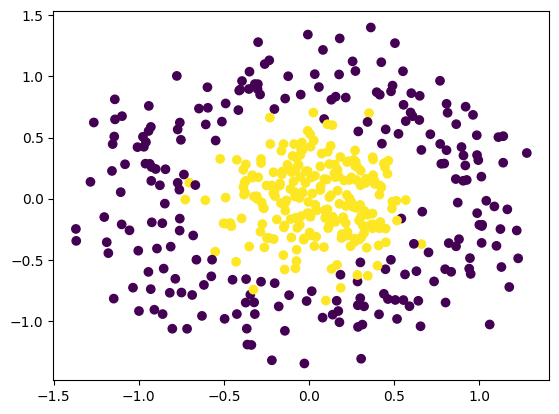

In [3]:
plot_2d_data(train_X,train_y)

In [4]:
s_params_size=3

In [5]:
dev = qml.device("default.qubit", wires=1)

In [18]:
@qml.qnode(dev)
def vqc_model(x_i, params):
    s_params,w_params = params[:s_params_size], params[s_params_size:]
#     encode_and_rotate(x_i, s_params,w_params)
    # scheme_a(x_i, s_params,w_params)
    # scheme_e(x_i, s_params,w_params)
    scheme_f(x_i, s_params,w_params)
    return qml.expval(qml.PauliZ(0))
@qml.qnode(dev)
def get_state(x_i,params):
    s_params,w_params = params[:s_params_size], params[s_params_size:]
    scheme_f(x_i, s_params,w_params)
    return [qml.expval(qml.PauliX(0)), qml.expval(qml.PauliY(0)), qml.expval(qml.PauliZ(0))]


In [7]:
def loss(data, labels, model, params):    
    loss_sum = []
    for idx in range(len(data)):
        data_point = data[idx]
        true_label = labels[idx]
        model_output = model(data_point, params)
        if (model_output<0 and true_label>0) or (model_output>0 and true_label<0):
#             print(model_output, true_label)
            loss_sum.append((model_output - true_label) ** 2)

    return sum(loss_sum)/len(data)
#     return sum(loss_sum)/len(loss_sum)
#     return loss_sum / len(data)


def make_prediction(model, data_point, params):
    measurement_result = model(data_point, params)
    if measurement_result < 0:
        return -1
    return 1


def compute_accuracy(data, labels, model, params):
    n_samples = len(data)
#     for x in range(n_samples):
#         print(make_prediction(model, data[x], params),labels[x])
    return np.sum(
        [make_prediction(model, data[x], params) == labels[x] for x in range(n_samples)
    ]) / n_samples

In [8]:
def get_initial_dataset(train_X,train_Y):
    size_to_return = int(0.04*len(train_X))
    curr_train_X, curr_train_y = [],[]
    idx = np.random.choice(len(train_X), size_to_return)
    for i in idx:
        curr_train_X.append(train_X[i])        
        curr_train_y.append(train_Y[i])
    curr_train_X = np.array(curr_train_X, requires_grad=False)
    curr_train_y = np.array(curr_train_y, requires_grad=False)
    return curr_train_X,curr_train_y

In [9]:
# start_point_itrs = 50

# for _ in range(start_point_itrs):
# print("__________________________________________________")
s_params_size, w_params_size = 3,3
params = np.random.normal(size=(s_params_size+w_params_size))#*100
# params = np.array([ 1.00302379, -0.03861783,  0.08039802,  1.81841197]) # these weights work very well with circular boundary
print(params)
# opt = qml.AdamOptimizer(stepsize=0.00087)
opt = qml.GradientDescentOptimizer(stepsize=0.009)
num_its = 220
loss_over_time = []
# curr_train_X, curr_train_y = get_initial_dataset(train_X,train_y)
for itr in range(num_its):
    (_, _, _, params), _loss = opt.step_and_cost(loss, train_X, train_y, vqc_model, params)
    loss_over_time.append(_loss)
    print("Iteration:",itr, "Loss:",_loss)



[ 1.65736474 -1.55409189 -0.03728643 -0.29941074 -1.36546026 -0.21824434]
Iteration: 0 Loss: 1.7118503301624295
Iteration: 1 Loss: 1.7045898405071014
Iteration: 2 Loss: 1.7063775572834952
Iteration: 3 Loss: 1.7037370041613533
Iteration: 4 Loss: 1.6987142599419287
Iteration: 5 Loss: 1.6956573147750997
Iteration: 6 Loss: 1.6923373209673789
Iteration: 7 Loss: 1.6911096519609836
Iteration: 8 Loss: 1.6854040428908603
Iteration: 9 Loss: 1.6819164198037366
Iteration: 10 Loss: 1.6786253896295877
Iteration: 11 Loss: 1.6773772346734113
Iteration: 12 Loss: 1.673806856617677
Iteration: 13 Loss: 1.6747537432888824
Iteration: 14 Loss: 1.6667703931705617
Iteration: 15 Loss: 1.669667218165644
Iteration: 16 Loss: 1.6703614620351033
Iteration: 17 Loss: 1.6644127154004462
Iteration: 18 Loss: 1.6627410115835657
Iteration: 19 Loss: 1.6585339209323584
Iteration: 20 Loss: 1.6538199173191064
Iteration: 21 Loss: 1.6465123415949734
Iteration: 22 Loss: 1.6370052171951728
Iteration: 23 Loss: 1.627055709767031
Ite

Iteration: 207 Loss: 0.5725219686196807
Iteration: 208 Loss: 0.5725131325364555
Iteration: 209 Loss: 0.5702824909285337
Iteration: 210 Loss: 0.5702758151616018
Iteration: 211 Loss: 0.5702691148908782
Iteration: 212 Loss: 0.5680408048516655
Iteration: 213 Loss: 0.5702566658334826
Iteration: 214 Loss: 0.5680277376954102
Iteration: 215 Loss: 0.5702441446924614
Iteration: 216 Loss: 0.5702373305231185
Iteration: 217 Loss: 0.5680088258974555
Iteration: 218 Loss: 0.5702246714158066
Iteration: 219 Loss: 0.5679956029293648


In [14]:
training_accuracy = compute_accuracy(train_X, train_y, vqc_model, params)
testing_accuracy = compute_accuracy(test_X, test_y, vqc_model, params)

print(f"Training accuracy = {training_accuracy}")
print(f"Testing accuracy = {testing_accuracy}")

Training accuracy = 0.66
Testing accuracy = 0.6


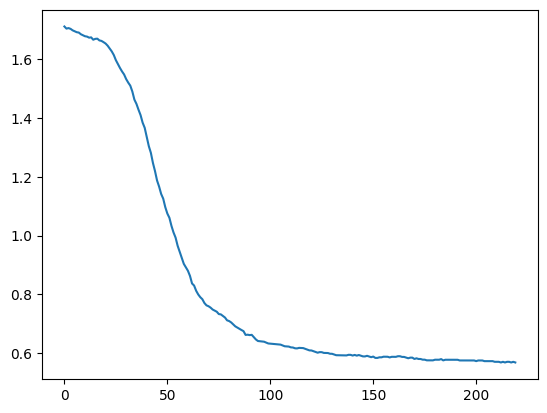

In [15]:
plt.plot(loss_over_time)
plt.show()

In [16]:
params

tensor([ 1.62972018, -1.67337412, -0.02099351, -0.80498161, -1.89927275,
         0.03378581], requires_grad=True)

In [19]:

op_state = []
X,Y,Z=[],[],[]
for i in range(len(train_X)):
    x,y,z = (get_state(train_X[i],params))
    X.append(x)
    Y.append(y)
    Z.append(z)
    op_state.append([y,z])
op_state = np.array(op_state)
X = np.array(X)
Y = np.array(Y)
Z = np.array(Z)




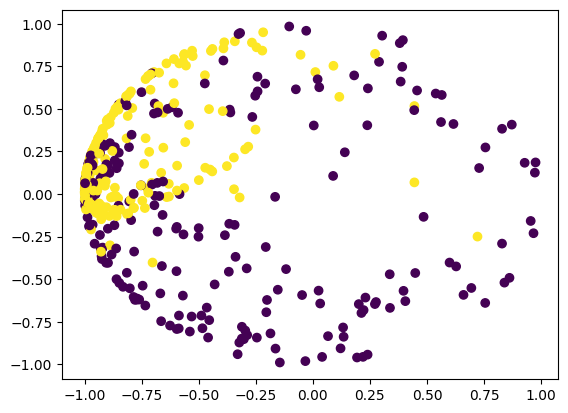

In [20]:
plot_2d_data(op_state,train_y)

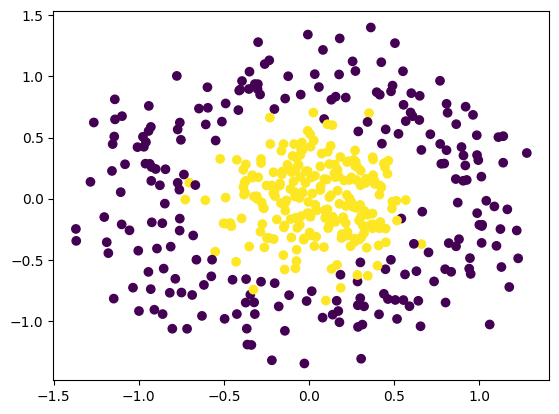

In [21]:
plot_2d_data(train_X,train_y)

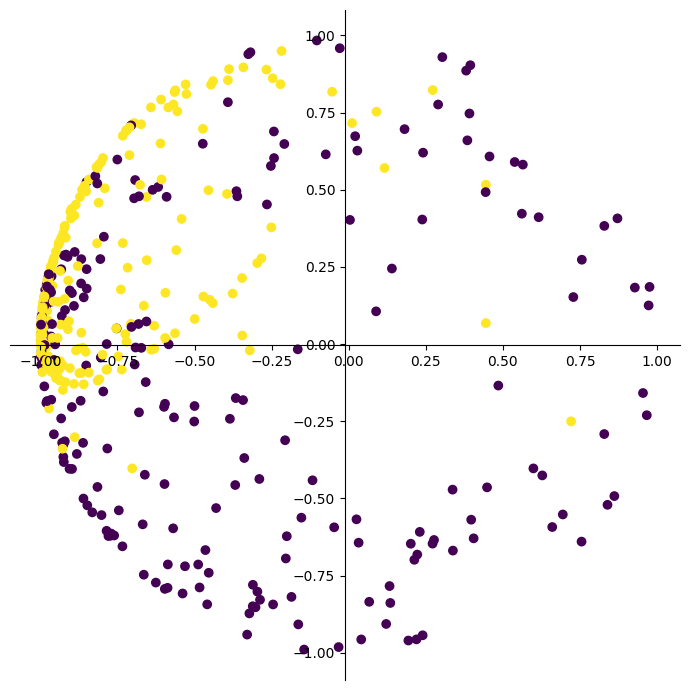

In [22]:
plt.rcParams["figure.figsize"] = [7.00, 7.00]
plt.rcParams["figure.autolayout"] = True
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.scatter(op_state[:, 0], op_state[:, 1], c=train_y)
# plt.legend(loc=1)
plt.show()

In [17]:
# https://qiskit-community.github.io/qiskit-machine-learning/stubs/qiskit_machine_learning.algorithms.VQC.html
# when benchmarking the WINE and IRIS for ternary classification

In [14]:
a = '9'
if a.isdigit():
    a = int(a)
print(a, type(a))

9 <class 'int'>


In [5]:
import os
os.listdir()

['.DS_Store',
 'requirements.txt',
 'datasets.py',
 'Qutrit Models.ipynb',
 'qubit_models.py',
 'run_qutrit.py',
 '__pycache__',
 'README.md',
 'recent_run.txt',
 '.gitignore',
 '.ipynb_checkpoints',
 '.git',
 'qutrit_models.py',
 'Qubit Models.ipynb',
 '07-handson-vqc',
 'helpers.py',
 'run_qubit.py']

In [9]:
os.system("python run_qubit.py --help")

usage: run_qubit.py [-h] [--encoding_and_rotation {A,B,C,D,E,F,G}]
                    [--dataset {xor,moon,circular}]
                    [--dataset_size DATASET_SIZE] [--num_itr NUM_ITR]

options:
  -h, --help            show this help message and exit
  --encoding_and_rotation {A,B,C,D,E,F,G}
                        choose the encoding and rotation scheme, default B
  --dataset {xor,moon,circular}
                        choose the dataset, default circular boundary
  --dataset_size DATASET_SIZE
                        Enter the dataset size
  --num_itr NUM_ITR     Enter number of iterations for training


0

In [23]:
key = jax.random.PRNGKey(0)
print(key)

[0 0]


In [24]:
key, split = jax.random.split(key)
key, split

(Array([4146024105,  967050713], dtype=uint32),
 Array([2718843009, 1272950319], dtype=uint32))

In [27]:
def a(m):
    m=0.3*m
    return m
newm = jax.grad(a)

In [28]:
newm(0)

TypeError: grad requires real- or complex-valued inputs (input dtype that is a sub-dtype of np.inexact), but got int32. If you want to use Boolean- or integer-valued inputs, use vjp or set allow_int to True.